# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

3.7.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14683655814904210239
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12942356825094362280
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:1f:00.0, compute capability: 6.1"
]


# Przygotowanie odpowiednich danych

In [2]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../data/Casia'
A_folder = 'originals'
B_folder = 'photoshops'

# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [5]:
# Wilkości odpowiednie dla ResNetu

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [6]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [7]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,../data/Casia/originals/Au_sec_30147.jpg,1
1,../data/Casia/photoshops/Tp_S_NRN_S_B_sec20014...,0
2,../data/Casia/originals/Au_nat_30329.jpg,1
3,../data/Casia/photoshops/Tp_D_NRN_S_N_sec00061...,0
4,../data/Casia/photoshops/Tp_S_CRN_M_N_nat10164...,0


In [9]:
df.shape

(12614, 2)

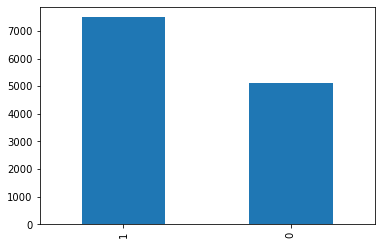

In [10]:
df['category'].value_counts().plot.bar()

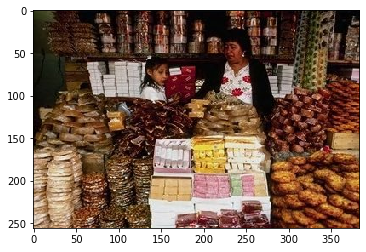

In [11]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka danych

In [12]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [13]:
df.head()

,filename,category
0,../data/Casia/originals/Au_sec_30147.jpg,1
1,../data/Casia/photoshops/Tp_S_NRN_S_B_sec20014...,0
2,../data/Casia/originals/Au_nat_30329.jpg,1
3,../data/Casia/photoshops/Tp_D_NRN_S_N_sec00061...,0
4,../data/Casia/photoshops/Tp_S_CRN_M_N_nat10164...,0


In [14]:
X.head()

,filename
0,../data/Casia/originals/Au_sec_30147.jpg
1,../data/Casia/photoshops/Tp_S_NRN_S_B_sec20014...
2,../data/Casia/originals/Au_nat_30329.jpg
3,../data/Casia/photoshops/Tp_D_NRN_S_N_sec00061...
4,../data/Casia/photoshops/Tp_S_CRN_M_N_nat10164...


In [15]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: category, dtype: int64

In [16]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych
test  - 20% danych
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

# Reset indeksów
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

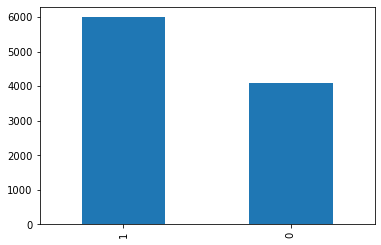

In [17]:
train['category'].value_counts().plot.bar()

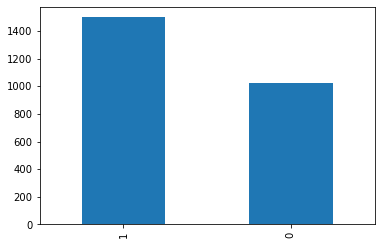

In [18]:
test['category'].value_counts().plot.bar()

In [19]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (12614, 2)
	 train: (10091, 2)
	 test: (2523, 2)


In [20]:
# Upewnienie się że dane w train[filename] i test[filename] są stringiem - lepsze dla generatorów

train['filename'] = train['filename'].astype(str) 
test['filename'] = test['filename'].astype(str)

# Upewnienie się że dane w train[category] i test[category] są stringiem - lepsze dla generatorów

train['category'] = train['category'].astype(str) 
test['category'] = test['category'].astype(str)

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (12614, 2)
	 train: (10091, 2)
	 test: (2523, 2)


# Funkcję liczące statystyki

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 15
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [27]:
# To Do

batch_size = 10
activation = 'relu'
loss_type = 'categorical_crossentropy'
optimizer = 'Adam'
dropout = 0.25
epochs = 50

# Generatory

In [28]:
'''
Generator dla danych trenningowych
'''

from keras.applications.resnet import preprocess_input

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = data_gen.flow_from_dataframe(
    dataframe = train,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 10091 validated image filenames belonging to 2 classes.


In [29]:
'''
Generator dla danych testowych
 * reskalowanie
'''

test_generator = data_gen.flow_from_dataframe( 
    dataframe = test,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 2523 validated image filenames belonging to 2 classes.


In [30]:
example_df = train.sample(n=1).reset_index(drop=True)

example_generator = data_gen.flow_from_dataframe(
    dataframe = example_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

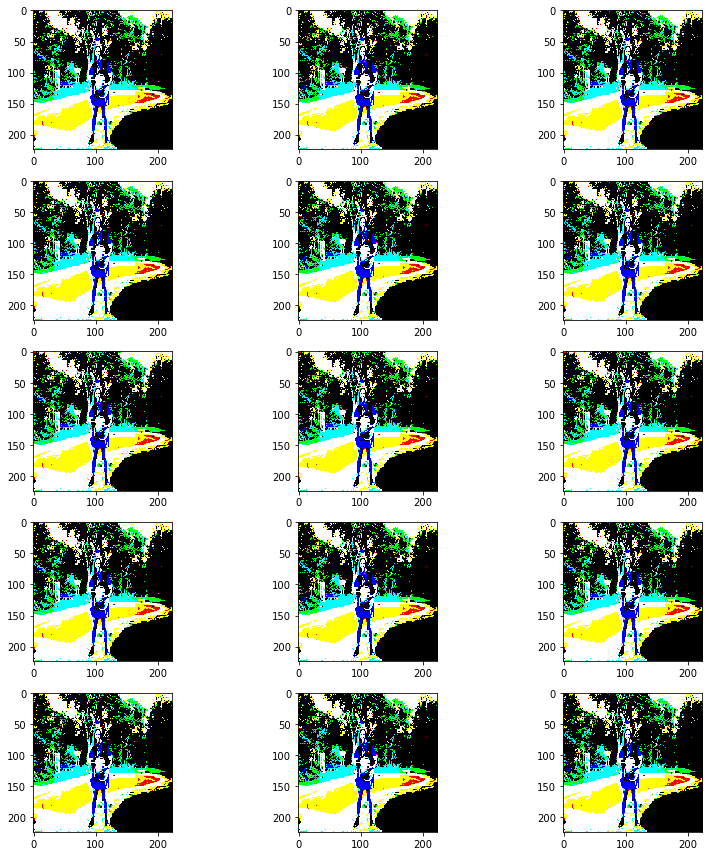

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Model Fine-Tuning

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

pre_trained_model_fn = ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet')

for layer in pre_trained_model_fn.layers[:38]:
    layer.trainable = False

for layer in pre_trained_model_fn.layers[38:]:
    layer.trainable = True

model_fn = Sequential()

model_fn.add(pre_trained_model_fn)
model_fn.add(Dropout(dropout))
model_fn.add(Dense(256, activation=activation))
model_fn.add(Dense(2, activation='softmax'))

model_fn.summary()

print(len(pre_trained_model_fn.trainable_weights))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 24,112,770
Trainable params: 23,832,834
Non-trainable params: 279,936
_________________________________________________________________
168


# ResNet bez żadnych wag wejściowych

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

pre_trained_model_v = ResNet50(include_top = True, weights = None, classes=2)

model_v = Sequential()

model_v.add(pre_trained_model_v)

model_v.summary()

print(len(model_v.trainable_weights))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2)                 23591810  
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________
214


# Fit

In [34]:
model_fn.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_fn = model_fn.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_fn.load_weights('best.h5')

# Zapis
model_fn.save('the_best_fn_P.h5')

Epoch 1/50
 398/1009 [==========>...................] - ETA: 2:27 - loss: 0.7042 - accuracy: 0.6128 - get_f1: 0.6128

d:\programs\python37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
d:\programs\python37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


1009/1009 [==============================] - 262s 260ms/step - loss: 0.6604 - accuracy: 0.6423 - get_f1: 0.6426 - val_loss: 0.5542 - val_accuracy: 0.6385 - val_get_f1: 0.6385

Epoch 00001: val_loss improved from inf to 0.55418, saving model to best.h5
Epoch 2/50
1009/1009 [==============================] - 222s 220ms/step - loss: 0.6007 - accuracy: 0.6833 - get_f1: 0.6835 - val_loss: 1.4165 - val_accuracy: 0.6216 - val_get_f1: 0.6217

Epoch 00002: val_loss did not improve from 0.55418
Epoch 3/50
1009/1009 [==============================] - 223s 221ms/step - loss: 0.5850 - accuracy: 0.7019 - get_f1: 0.7022 - val_loss: 0.1906 - val_accuracy: 0.6817 - val_get_f1: 0.6816

Epoch 00003: val_loss improved from 0.55418 to 0.19063, saving model to best.h5
Epoch 4/50
1009/1009 [==============================] - 222s 220ms/step - loss: 0.5630 - accuracy: 0.7169 - get_f1: 0.7171 - val_loss: 0.5903 - val_accuracy: 0.6872 - val_get_f1: 0.6862

Epoch 00004: val_loss did not improve from 0.19063
Epoch

In [35]:
'''
odświeżenie callbacków
'''

EARLY_STOP_PATIENCE = 15
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

In [36]:
model_v.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_v = model_v.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_v.load_weights('best.h5')

# Zapis
model_v.save('the_best_v_P.h5')

Epoch 1/50
 624/1009 [=================>............] - ETA: 1:53 - loss: 0.7935 - accuracy: 0.5790 - get_f1: 0.5796

d:\programs\python37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
d:\programs\python37\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


1009/1009 [==============================] - 311s 308ms/step - loss: 0.7488 - accuracy: 0.5916 - get_f1: 0.5920 - val_loss: 0.5034 - val_accuracy: 0.5929 - val_get_f1: 0.5929

Epoch 00001: val_loss improved from inf to 0.50338, saving model to best.h5
Epoch 2/50
1009/1009 [==============================] - 296s 293ms/step - loss: 0.6869 - accuracy: 0.5918 - get_f1: 0.5922 - val_loss: 1.1262 - val_accuracy: 0.5981 - val_get_f1: 0.5992

Epoch 00002: val_loss did not improve from 0.50338
Epoch 3/50
1009/1009 [==============================] - 296s 293ms/step - loss: 0.6804 - accuracy: 0.5990 - get_f1: 0.5994 - val_loss: 1.3586 - val_accuracy: 0.5611 - val_get_f1: 0.5604

Epoch 00003: val_loss did not improve from 0.50338
Epoch 4/50
1009/1009 [==============================] - 296s 293ms/step - loss: 0.6702 - accuracy: 0.6137 - get_f1: 0.6141 - val_loss: 3.8385 - val_accuracy: 0.5651 - val_get_f1: 0.5644

Epoch 00004: val_loss did not improve from 0.50338
Epoch 5/50
1009/1009 [============

# Statystyki

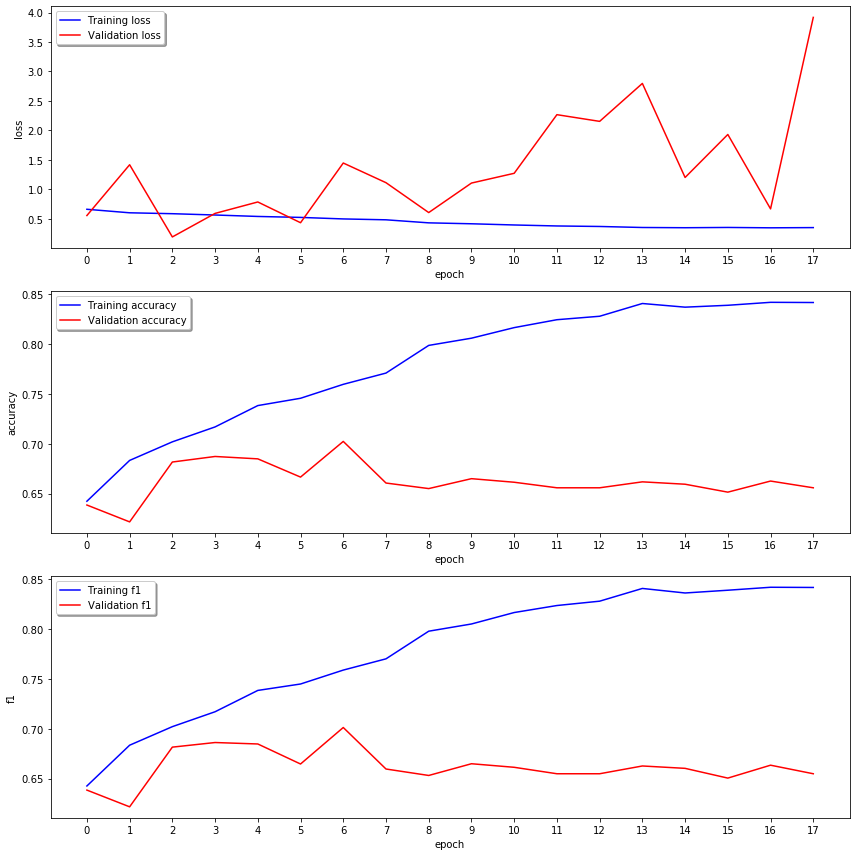

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_fn.history['loss'], color='b', label="Training loss")
ax1.plot(history_fn.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_fn.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_fn.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_fn.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_fn.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_fn.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_fn.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_fn.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

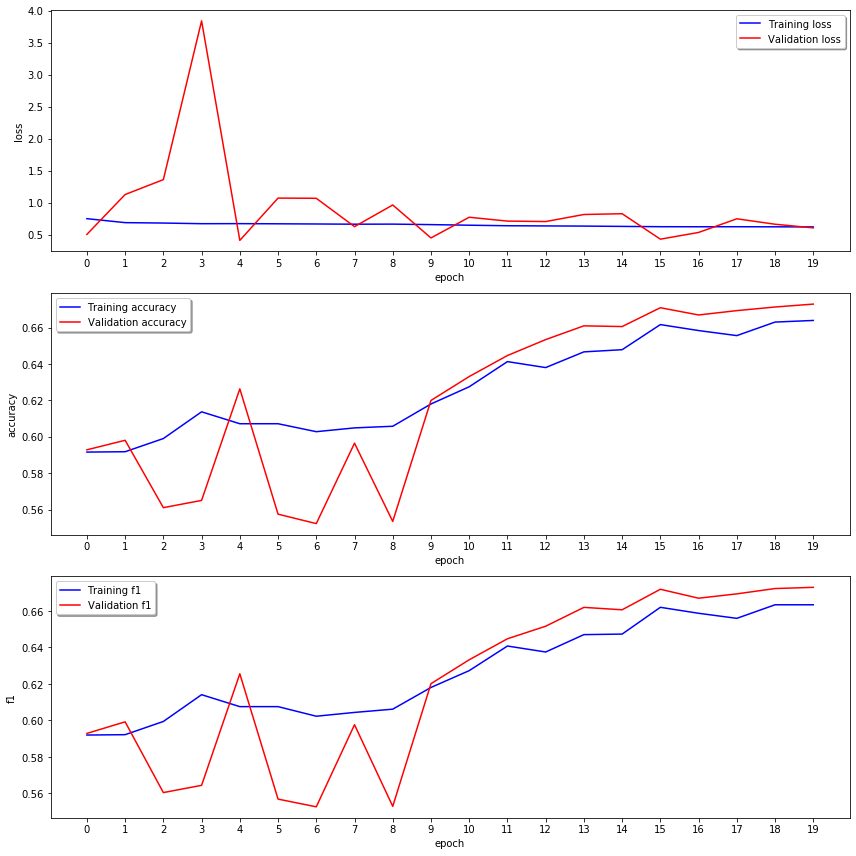

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_v.history['loss'], color='b', label="Training loss")
ax1.plot(history_v.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_v.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_v.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_v.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_v.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_v.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_v.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_v.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [40]:
stats_df = pd.DataFrame({
    'filename': test['filename'],
    'category': test['category'],
    'predict_fn': None,
    'predict_v': None
})

# Mieszamy!
stats_df = stats_df.sample(frac=1).reset_index(drop=True)

stats_df.head()

,filename,category,predict_fn,predict_v
0,../data/Casia/originals/Au_cha_30280.jpg,1,None,None
1,../data/Casia/originals/Au_art_30645.jpg,1,None,None
2,../data/Casia/photoshops/Tp_S_NNN_S_N_art00095...,0,None,None
3,../data/Casia/photoshops/Tp_S_NRN_S_N_sec20046...,0,None,None
4,../data/Casia/originals/Au_cha_30105.jpg,1,None,None


In [41]:
validate_generator = data_gen.flow_from_dataframe( 
    dataframe = stats_df,
    x_col = 'filename',
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2523 validated image filenames.


In [42]:
predict_fn = model_fn.predict_generator(validate_generator, verbose=True)

predict_v = model_v.predict_generator(validate_generator, verbose=True)

253/253 [==============================] - 19s 74ms/step


In [43]:
# Zamiana z one hot encodera na jedno wyjście
stats_df['predict_fn'] = numpy.argmax(predict_fn, axis=-1)
stats_df['predict_v'] = numpy.argmax(predict_v, axis=-1)

In [44]:
stats_df.head()

,filename,category,predict_fn,predict_v
0,../data/Casia/originals/Au_cha_30280.jpg,1,1,1
1,../data/Casia/originals/Au_art_30645.jpg,1,1,1
2,../data/Casia/photoshops/Tp_S_NNN_S_N_art00095...,0,1,0
3,../data/Casia/photoshops/Tp_S_NRN_S_N_sec20046...,0,0,1
4,../data/Casia/originals/Au_cha_30105.jpg,1,1,1


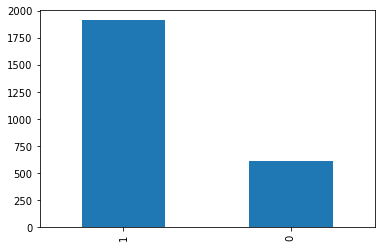

In [45]:
stats_df['predict_fn'].value_counts().plot.bar()

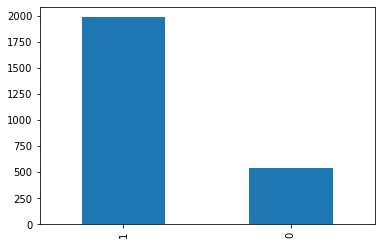

In [46]:
stats_df['predict_v'].value_counts().plot.bar()

In [47]:
y_true_fn = stats_df['category'].to_numpy().astype(int)
y_pred_fn = stats_df['predict_fn'].to_numpy().astype(int)

y_true_v = stats_df['category'].to_numpy().astype(int)
y_pred_v = stats_df['predict_v'].to_numpy().astype(int)

In [48]:
cm_fn = confusion_matrix(y_true_fn, y_pred_fn)
cm_v = confusion_matrix(y_true_v, y_pred_v)

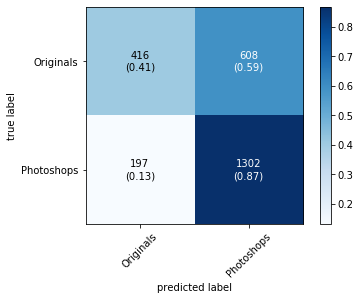

In [49]:
plot_cm(cm_fn, ['Originals', 'Photoshops'])

In [50]:
print(cm_fn)

[[ 416  608]
 [ 197 1302]]


In [51]:
loss, accuracy, get_f1  = model_fn.evaluate_generator(test_generator, verbose=True)

253/253 [==============================] - 18s 70ms/step


In [52]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

Test loss: 3.1
Test accuracy: 0.681
Test F1: 0.679


In [53]:
accuracy, precision, recall, fscore = countStats(y_true_fn, y_pred_fn)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.6809353943717796
Precision: 0.6804392454311057
Recall: 0.6809353943717796
F-score: 0.6601155013828673


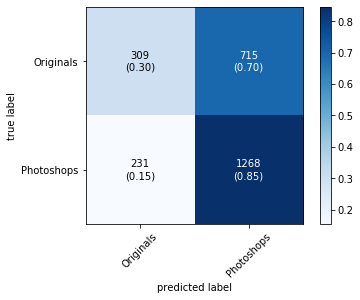

In [54]:
plot_cm(cm_v, ['Originals', 'Photoshops'])

In [55]:
print(cm_v)

[[ 309  715]
 [ 231 1268]]


In [56]:
loss, accuracy, get_f1  = model_v.evaluate_generator(test_generator, verbose=True)

253/253 [==============================] - 18s 70ms/step


In [57]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

Test loss: 0.143
Test accuracy: 0.625
Test F1: 0.626


In [58]:
accuracy, precision, recall, fscore = countStats(y_true_v, y_pred_v)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.6250495441934205
Precision: 0.6121557348973742
Recall: 0.6250495441934205
F-score: 0.5930920779245569
